# Data Engineering 

This bootcamp will be all about wrangling, merging, casting and imputing our data to make it usable for analysis. We will work with time series and complex built up datasets. To prepare you for real world data we will use the Smart meter in London dataset from kaggle: https://www.kaggle.com/jeanmidev/smart-meters-in-london 

In [ ]:
# Import the needed libraries 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import datetime
import os
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
#import pyflux as pf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Download the dataset
# https://drive.google.com/file/d/13AuIcqWL5ix6Dw8uQYaykKbdA1ZdGdoL/view?usp=sharing

!gdown --id 13AuIcqWL5ix6Dw8uQYaykKbdA1ZdGdoL

Downloading...
From: https://drive.google.com/uc?id=13AuIcqWL5ix6Dw8uQYaykKbdA1ZdGdoL
To: /content/Smart_meters_London.zip
100% 103M/103M [00:01<00:00, 78.5MB/s] 


In [ ]:
# Unzip the files

from zipfile import ZipFile
file_name="/content/Smart_meters_London.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
acorn = pd.read_csv('/content/Smart_meters_London/acorn_details.csv', encoding= 'unicode_escape')
acorn

,MAIN CATEGORIES,CATEGORIES,REFERENCE,ACORN-A,ACORN-B,ACORN-C,ACORN-D,ACORN-E,ACORN-F,ACORN-G,ACORN-H,ACORN-I,ACORN-J,ACORN-K,ACORN-L,ACORN-M,ACORN-N,ACORN-O,ACORN-P,ACORN-Q
0,POPULATION,Age,Age 0-4,77.0,83.0,72.0,100.0,120.0,77.0,97.0,97.0,63.0,119.0,67.0,114.0,113.0,89.0,123.0,138.0,133.0
1,POPULATION,Age,Age 5-17,117.0,109.0,87.0,69.0,94.0,95.0,102.0,106.0,67.0,95.0,64.0,108.0,116.0,86.0,89.0,136.0,106.0
2,POPULATION,Age,Age 18-24,64.0,73.0,67.0,107.0,100.0,71.0,83.0,89.0,62.0,104.0,459.0,97.0,96.0,86.0,117.0,109.0,110.0
3,POPULATION,Age,Age 25-34,52.0,63.0,62.0,197.0,151.0,66.0,90.0,88.0,63.0,132.0,145.0,109.0,96.0,90.0,140.0,120.0,120.0
4,POPULATION,Age,Age 35-49,102.0,105.0,91.0,124.0,118.0,93.0,102.0,103.0,76.0,111.0,67.0,99.0,98.0,90.0,102.0,103.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,LEISURE TIME,Holiday Destination/Type,Asia,171.0,137.0,94.0,220.0,196.0,69.0,122.0,95.0,72.0,97.0,124.0,73.0,57.0,49.0,96.0,113.0,63.0
822,LEISURE TIME,Holiday Destination/Type,Activity / Outdoor Sports,298.0,278.0,138.0,119.0,93.0,96.0,113.0,96.0,84.0,96.0,56.0,48.0,48.0,46.0,23.0,23.0,23.0
823,LEISURE TIME,Holiday Destination/Type,Cruise,272.0,295.0,272.0,44.0,44.0,70.0,70.0,70.0,70.0,70.0,28.0,28.0,28.0,28.0,49.0,49.0,49.0
824,LEISURE TIME,Holiday Destination/Type,Package,196.0,186.0,166.0,49.0,49.0,101.0,101.0,121.0,106.0,101.0,48.0,75.0,75.0,75.0,54.0,54.0,54.0


# Part 1

### Exersice 1

A) Have a look at [the acorn userguide](https://www.caci.co.uk/sites/default/files/resources/Acorn%20User%20Guide%202020.pdf) to get some insight on what this data means.

B) Look up the value of the category "Playing Golf" for Acorn-A. What does this value mean?

C) Rename the collumns to give each "ACORN" the name that's stated in the user guide. (I've been so kind to provide you with the dictionaire beforehand :)

D) Transpose the dataset so that the categories become the collumn names, the refernces become the sub-collumn names, and the household types are the rows. (Tip: This is called Multi Indexing, you can look it up ;) It should look something like this: 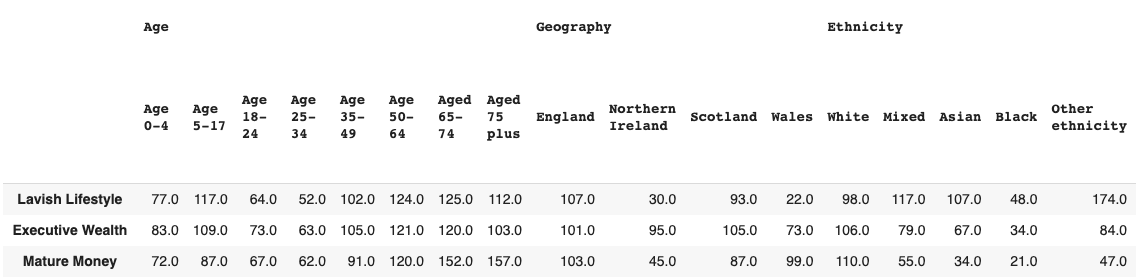


In [ ]:
acorn = acorn.rename(columns={'ACORN-A':'Lavish Lifestyle','ACORN-B':'Executive Wealth','ACORN-C':'Mature Money',
                      'ACORN-D':'City Sophisticates','ACORN-E':'Career Climber','ACORN-F':'Countryside Communities',
                      'ACORN-G':'Successful Suburbs','ACORN-H':'Steady Neaighbourhoods','ACORN-I':'Comfortable Seniors',
                      'ACORN-J':'Starting Out','ACORN-K':'Student Life','ACORN-L':'Modest Means',
                      'ACORN-M':'Striving Families','ACORN-N':'Poorer Pensioners','ACORN-O':'Young Hardship',
                      'ACORN-P':'Struggling Estates','ACORN-Q':'Difficult Circumstances'},errors="raise")
categories = np.asarray(acorn.CATEGORIES)
reference = np.asarray(acorn.REFERENCE)
columns = [categories ,reference] 
household_types = list(acorn.columns[3:21])
acorn = acorn.drop(columns=['MAIN CATEGORIES','CATEGORIES','REFERENCE'])
acorn = acorn.transpose().to_numpy()

In [ ]:
df = pd.DataFrame(acorn, index=household_types, columns=columns)
df

Age                     ... Holiday Destination/Type                      
                        Age 0-4 Age 5-17 Age 18-24  ...                   Cruise Package Self-catering
Lavish Lifestyle           77.0    117.0      64.0  ...                    272.0   196.0         308.0
Executive Wealth           83.0    109.0      73.0  ...                    295.0   186.0         181.0
Mature Money               72.0     87.0      67.0  ...                    272.0   166.0         181.0
City Sophisticates        100.0     69.0     107.0  ...                     44.0    49.0          55.0
Career Climber            120.0     94.0     100.0  ...                     44.0    49.0          55.0
Countryside Communities    77.0     95.0      71.0  ...                     70.0   101.0         127.0
Successful Suburbs         97.0    102.0      83.0  ...                     70.0   101.0         147.0
Steady Neaighbourhoods     97.0    106.0      89.0  ...                     70.0   121.0         124.0
Comfortable Seniors        63.0     67.0      62.0  ...                     70.0   106.0         113.0
Starting Out              119.0     95.0     104.0  ...                     70.0   101.0         166.0
Student Life               67.0     64.0     459.0  ...                     28.0    48.0          44.0
Modest Means              114.0    108.0      97.0  ...                     28.0    75.0          44.0
Striving Families         113.0    116.0      96.0  ...                     28.0    75.0          44.0
Poorer Pensioners          89.0     86.0      86.0  ...                     28.0    75.0          33.0
Young Hardship            123.0     89.0     117.0  ...                     49.0    54.0          32.0
Struggling Estates        138.0    136.0     109.0  ...                     49.0    54.0          35.0
Difficult Circumstances   133.0    106.0     110.0  ...                     49.0    54.0          35.0

[17 rows x 826 columns]

### Exercise 2

A) look up the unique values for categories.

B) Create a subset of the category 'Car Ownership'.

C) What household type is most likely to have 3 cars or more?

D) What household type is least likely to have an Iphone?

In [ ]:
np.unique(categories)

array(['Action', 'Age', 'Attitude', 'Attitudes', 'Behaviours & Lifestyle',
       'Benefits', 'Books Read', 'Car Ownership', 'Channels Received',
       'Charities', 'Children in household', 'Clothing & Footwear Stores',
       'Country of Birth', 'Credit Cards', 'Crime Survey for England',
       'Daily Newspapers', 'Digital Attitudes', 'Economic Activity',
       'Electrical Stores', 'England: Pupils at the end of KS1',
       'England: Pupils at the end of KS2',
       'England: Pupils at the end of KS4', 'Environmental Groups',
       'Ethnicity', 'Expenditure per person per week',
       'Financial Attitudes',
       'Financial Channel: Arrange Current Account',
       'Financial Channel: Arrange commoditised financial product',
       'Financial Channel: Arrange considered financial product',
       'Financial Channel: Manage Current Account',
       'Financial Channel: Manage Savings Account', 'Financial Situation',
       'Food Shopping', 'Furniture & Fittings Stores', 'Future 

In [ ]:
category = df[['Smartphone Brand']]
category

Smartphone Brand         ...                      
                              BlackBerry iPhone  ... Samsung Sony Ericsson
Lavish Lifestyle                   151.0  145.0  ...    91.0          87.0
Executive Wealth                   109.0  128.0  ...    94.0          88.0
Mature Money                        98.0   98.0  ...    88.0          78.0
City Sophisticates                 166.0  167.0  ...    99.0          91.0
Career Climber                     133.0  151.0  ...   111.0         100.0
Countryside Communities             97.0   82.0  ...    98.0         101.0
Successful Suburbs                  97.0  110.0  ...    98.0          90.0
Steady Neaighbourhoods              97.0  108.0  ...   106.0          95.0
Comfortable Seniors                 69.0   62.0  ...    75.0          82.0
Starting Out                        97.0  119.0  ...   109.0          95.0
Student Life                       101.0  140.0  ...   114.0         131.0
Modest Means                        87.0   92.0  ...   103.0         100.0
Striving Families                   87.0   90.0  ...   107.0         100.0
Poorer Pensioners                   67.0   55.0  ...    80.0          89.0
Young Hardship                     106.0   91.0  ...   106.0         126.0
Struggling Estates                 114.0   99.0  ...   104.0         108.0
Difficult Circumstances            106.0   75.0  ...    99.0         122.0

[17 rows x 8 columns]

### Exercise 3

A) What household has the lowest score most frequently?

B) What household has the highest score most frequently?

In [ ]:
min_dict = {}
for column in np.unique(df.columns):
  minvalue = df[column].idxmin()
  if minvalue in min_dict:
    min_dict[minvalue] += 1
  if minvalue not in min_dict:
    min_dict[minvalue] = 1

max_dict = {}
for column in np.unique(df.columns):
  maxvalue = df[column].idxmax()
  if maxvalue in max_dict:
    max_dict[maxvalue] += 1
  if maxvalue not in max_dict:
    max_dict[maxvalue] = 1

print('Lowest score most frequently:', max(min_dict, key = min_dict.get),'\nHighest score most frequently:', max(max_dict, key = max_dict.get))

Lowest score most frequently: Poorer Pensioners 
Highest score most frequently: City Sophisticates


# Part 2

### Exercise 1

From here we will try to predict the overall energy consumption in London for a certain time. Have a look at the Smart_meters_London/daily_dataset/daily_dataset folder.

A) Open block_0.csv and take a look at the columns

B) Find out what the column LCLid means

Now we will try to combine all block.csv files and create 1 dataframe that contains all information.

C) Open a new csv file to write a new dataframe to. Name it "blocks_combined"

D) Append the dataframe from block_0 to blocks_combined

E) Create a loop to append all "block_x.csv" files to your new blocks_combined file so that you have all the information in one dataframe

In [ ]:
block = pd.read_csv('/content/Smart_meters_London/daily_dataset/daily_dataset/block_0.csv')
block

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000002,2012-10-12,0.1385,0.154304,0.886,46,0.196034,7.098,0.000
1,MAC000002,2012-10-13,0.1800,0.230979,0.933,48,0.192329,11.087,0.076
2,MAC000002,2012-10-14,0.1580,0.275479,1.085,48,0.274647,13.223,0.070
3,MAC000002,2012-10-15,0.1310,0.213688,1.164,48,0.224483,10.257,0.070
4,MAC000002,2012-10-16,0.1450,0.203521,0.991,48,0.184115,9.769,0.087
...,...,...,...,...,...,...,...,...,...
25569,MAC005492,2014-02-24,0.1690,0.175042,0.378,48,0.073174,8.402,0.079
25570,MAC005492,2014-02-25,0.1550,0.160792,0.545,48,0.082118,7.718,0.079
25571,MAC005492,2014-02-26,0.1490,0.178542,0.687,48,0.120820,8.570,0.079
25572,MAC005492,2014-02-27,0.1140,0.146167,0.478,48,0.082616,7.016,0.079


In [ ]:
# open a new csv file to write in
blocks_combined = open("blocks_combined.csv","a")
# write the first block to your new fill (to get the header):
for line in open("/content/Smart_meters_London/daily_dataset/daily_dataset/block_0.csv"):
  blocks_combined.write(line)
# now the rest:    
for num in range(1,112):
  f = open("/content/Smart_meters_London/daily_dataset/daily_dataset/block_"+str(num)+".csv")
  f.readline() # skip the header
  for line in f:
    blocks_combined.write(line)
  f.close()
blocks_combined.close()

In [ ]:
blocks_combined = pd.read_csv('blocks_combined.csv')
blocks_combined

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000002,2012-10-12,0.1385,0.154304,0.886,46,0.196034,7.098,0.000
1,MAC000002,2012-10-13,0.1800,0.230979,0.933,48,0.192329,11.087,0.076
2,MAC000002,2012-10-14,0.1580,0.275479,1.085,48,0.274647,13.223,0.070
3,MAC000002,2012-10-15,0.1310,0.213688,1.164,48,0.224483,10.257,0.070
4,MAC000002,2012-10-16,0.1450,0.203521,0.991,48,0.184115,9.769,0.087
...,...,...,...,...,...,...,...,...,...
3510428,MAC004828,2014-02-24,0.0225,0.053896,0.722,48,0.125341,2.587,0.000
3510429,MAC004828,2014-02-25,0.0050,0.015000,0.051,48,0.017029,0.720,0.000
3510430,MAC004828,2014-02-26,0.0110,0.021896,0.152,48,0.030538,1.051,0.000
3510431,MAC004828,2014-02-27,0.0045,0.015333,0.092,48,0.020424,0.736,0.000


### Exercise 2

A) See if blocks_combined has missing values.

B) Use the Iterative Imputer from SKlearn to impute the missing values in columns 'energy_std'

C) Check the mean and std of blocks combined with pandas profiling, and compare it with the mean and std of the column 'energy_std' with imputed values.

D) Use sample_posterior = True to do multiple imputation instead of single imputation and generate new values. 

E) Do the same as for 2C and check if there is any difference in mean and std.

F) Replace the NaN values with the values you imputed at 2D

In [ ]:
!pip install pandas_profiling==2.9.0 -U -q

In [ ]:
from pandas_profiling import ProfileReport
ProfileReport(blocks_combined, minimal=True)

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
blocks2 = blocks_combined.drop(columns=['LCLid','day'])
imp = IterativeImputer(random_state=0, min_value=0)
blocks_imp = imp.fit_transform(blocks2)
blocks_imp = blocks_imp[:,4]
blocks_imp

array([0.19603388, 0.19232901, 0.27464724, ..., 0.0305379 , 0.02042353,
       0.02089214])

In [ ]:
print(np.mean(blocks_imp))
print(np.std(blocks_imp))
print(np.min(blocks_imp))
print(np.max(blocks_imp))
print(np.median(blocks_imp))
print(np.var(blocks_imp))

0.17213474681711385
0.1531601364780671
0.0
4.0245693445140125
0.13231455643266024
0.023458027405980134


In [ ]:
imp2 = IterativeImputer(sample_posterior=True, min_value=0)
blocks_imp2 = imp2.fit_transform(blocks2)
blocks_imp2 = blocks_imp2[:,4]
blocks_imp2

array([0.19603388, 0.19232901, 0.27464724, ..., 0.0305379 , 0.02042353,
       0.02379112])

In [ ]:
print(np.mean(blocks_imp2))
print(np.std(blocks_imp2))
print(np.min(blocks_imp2))
print(np.max(blocks_imp2))
print(np.median(blocks_imp2))
print(np.var(blocks_imp2))

0.17216177559021395
0.15313466271076137
0.0
4.0245693445140125
0.13231455643266024
0.02345022492353865


In [ ]:
blocks_combined['energy_std'] = blocks_imp2

### Exercise 3

Now that we have our data set we can start exploring it. If you did exercise 1 right you found out that LCLid corresponds with the household ID. Now, before we start running models on our data it is important to know what our training data looks like.

A) Use value_counts() to make a count plot of the column 'day'

B) Transform the dtype of column 'day' from object to datetime

C) Make the same plot from 2A again

D) What does this plot tell you?

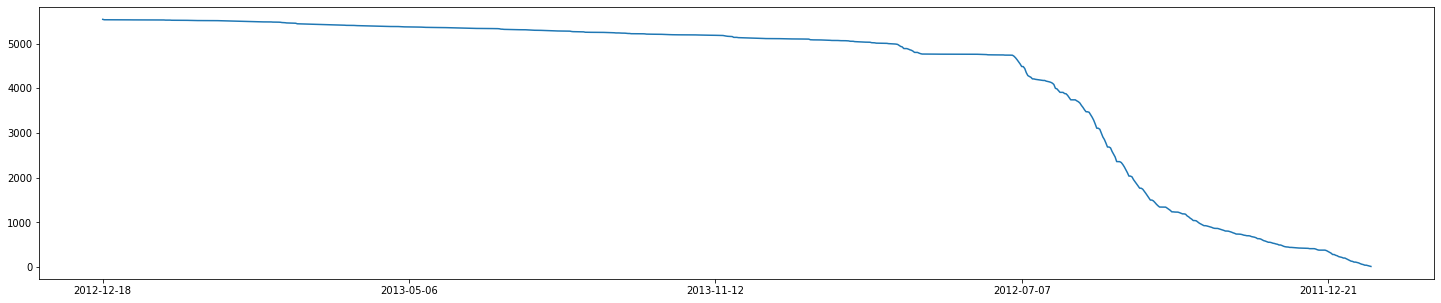

In [ ]:
counts = blocks_combined.day.value_counts()
counts.plot(figsize = (25,5))

In [ ]:
blocks_combined.day = pd.to_datetime(blocks_combined.day)

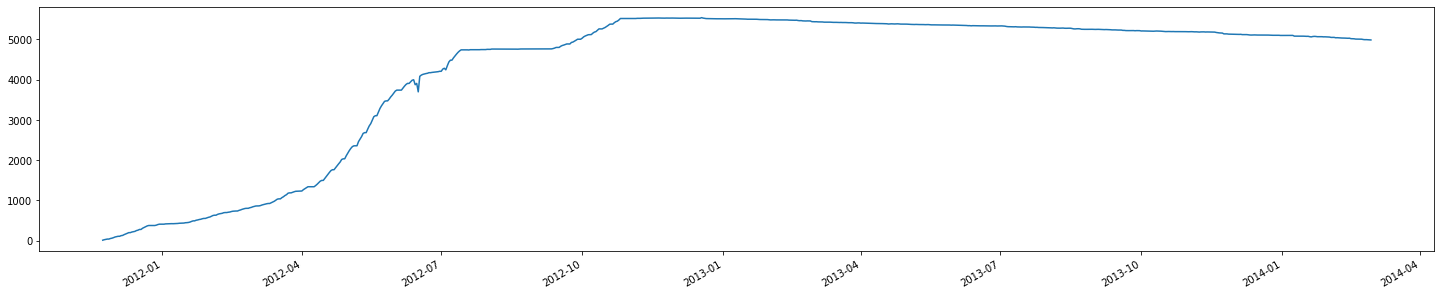

In [ ]:
counts = blocks_combined.day.value_counts()
counts.plot(figsize = (25,5))

### Exercise 4

In order to make accurate predictions for energy consumption it is important that the data is consistant. Therefore we will make a new dataframe called "energy_per_household" that takes into account how many houses were using a smart meter at a certain time.

A) Create a dataframe with a variable called 'nHouses' that holds the number of houses measured for each date.

B) Create a dataframe with a variable called 'energy_sum' that holds the total sum of all energy used on a date.

C) Merge these 2 new dataframes together and add a variable called 'avg_energy' that holds the average energy consumption per household.

In [ ]:
nHouses = blocks_combined.groupby('day')[['LCLid']].nunique()
nHouses = nHouses.rename(columns= {'LCLid':'nHouses'})
nHouses.head(4)

,nHouses
day,
2011-11-23,13
2011-11-24,25
2011-11-25,32
2011-11-26,41


In [ ]:
energy_per_house = blocks_combined.groupby('day')[['energy_sum']].sum()
energy_per_house = energy_per_house.merge(nHouses, on = ['day'])
energy_per_house['avg_energy'] =  energy_per_house['energy_sum']/energy_per_house['nHouses']
energy_per_house = energy_per_house.reset_index()
energy_per_house

,day,energy_sum,nHouses,avg_energy
0,2011-11-23,90.385000,13,6.952692
1,2011-11-24,213.412000,25,8.536480
2,2011-11-25,303.993000,32,9.499781
3,2011-11-26,420.976000,41,10.267707
4,2011-11-27,444.883001,41,10.850805
...,...,...,...,...
824,2014-02-24,51994.547004,4994,10.411403
825,2014-02-25,51423.508001,4995,10.294997
826,2014-02-26,50943.305995,4993,10.202945
827,2014-02-27,51678.185998,4990,10.356350


### Exercise 5

A) Add a column that states if the date is a weekend day (use pandas.datetime)

B) Check the difference in avg_energy between week days and weekend days

In [ ]:
energy_per_house['weekend'] = np.where((pd.to_datetime(energy_per_house['day']).dt.dayofweek) < 5,0,1)
energy_per_house

,day,energy_sum,nHouses,avg_energy,weekend
0,2011-11-23,90.385000,13,6.952692,0
1,2011-11-24,213.412000,25,8.536480,0
2,2011-11-25,303.993000,32,9.499781,0
3,2011-11-26,420.976000,41,10.267707,1
4,2011-11-27,444.883001,41,10.850805,1
...,...,...,...,...,...
824,2014-02-24,51994.547004,4994,10.411403,0
825,2014-02-25,51423.508001,4995,10.294997,0
826,2014-02-26,50943.305995,4993,10.202945,0
827,2014-02-27,51678.185998,4990,10.356350,0


In [ ]:
energy_per_house.groupby(['weekend']).mean()

,energy_sum,nHouses,avg_energy
weekend,,,
0,42300.756977,4235.436762,10.205444
1,44302.857707,4232.283898,10.742938


### Exercise 6

Now that we have our target variables. We will add weather information to see if we can predict energy consumption. 

A) Open the 'weather_daily_darksky.csv' file and have a look at the variables

B) Add a new variable called 'day' that has dtype datetime. Use 'time' to create this variable

C) Select all the numeric variables and drop all missing values.

D) Merge your new weather dataframe with the energy_per_household dataframe on 'day'

E) Run the plot and have a look at the relationship between temperature and engery consumption

In [ ]:
weather = pd.read_csv('/content/Smart_meters_London/weather_daily_darksky.csv')
weather.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,10.87,rain,3.30,0.95,2011-11-11 19:00:00,10.87,11.96,1.0,2011-11-11 00:00:00,2011-11-11 16:19:21,10.87,8.85,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,5.62,rain,12.09,0.88,2011-12-11 19:00:00,-0.64,5.72,1.0,2011-12-11 00:00:00,2011-12-11 15:52:53,3.09,2.48,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,10.33,rain,13.39,0.74,2011-12-27 14:00:00,5.52,10.33,0.0,2011-12-27 00:00:00,2011-12-27 15:57:56,8.03,8.03,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,5.33,rain,11.89,0.87,2011-12-02 12:00:00,3.26,5.33,1.0,2011-12-02 00:00:00,2011-12-02 15:56:17,6.33,2.56,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,5.02,rain,13.16,0.80,2011-12-24 15:00:00,4.37,5.32,1.0,2011-12-24 00:00:00,2011-12-24 15:55:55,7.45,3.17,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99


In [ ]:
weather['day']=  pd.to_datetime(weather['time'],format='%Y-%m-%d').dt.date

weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]

In [ ]:
energy_per_house['day'] = energy_per_house['day'].dt.date
weather_energy =  energy_per_house.merge(weather,on='day')

In [ ]:
weather_energy.head()

,day,energy_sum,nHouses,avg_energy,weekend,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385000,13,6.952692,0,10.36,229,6.29,0.36,2.04,1027.12,10.36,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94
1,2011-11-24,213.412000,25,8.536480,0,12.93,204,8.56,0.41,4.04,1027.22,12.93,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97
2,2011-11-25,303.993000,32,9.499781,0,13.03,243,7.24,0.48,5.02,1024.47,12.27,12.38,0.79,4.69,13.03,1.0,7.01,7.46,12.27,4.84,0.01
3,2011-11-26,420.976000,41,10.267707,1,12.96,237,6.96,0.44,5.75,1025.80,12.96,13.07,0.81,11.59,12.96,1.0,11.59,7.01,12.96,4.69,0.05
4,2011-11-27,444.883001,41,10.850805,1,13.54,256,5.76,0.42,5.48,1021.11,13.54,13.08,0.72,1.31,13.54,1.0,1.31,4.47,13.54,2.94,0.08


No handles with labels found to put in legend.
No handles with labels found to put in legend.


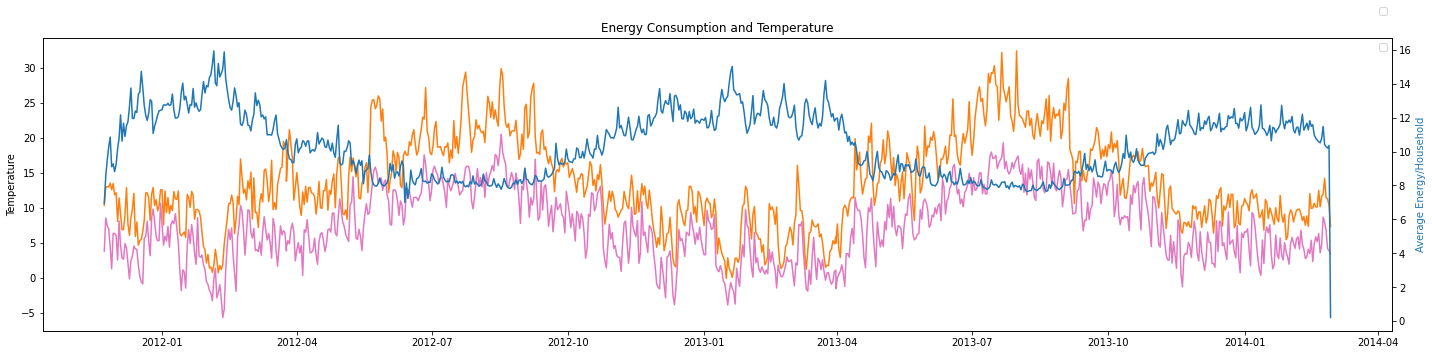

In [ ]:
#code for the plot from 6E

fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:orange')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

### Exercise 7 Advanced

A) Make a correlation matrix of the weather variables and avg_energy. 

You will see that there is a lot of multicollinearity in this dataset. That is because apparent temperatures are a function of other variables like humidity, tempratureMax, and windspeed.

B) Delete all columns with "apparent' in the name

C) Run a feature selection algorithm of your choice to select the optimal amount of features.

D) Make a new dataframe that only consists of variables that were selected during feature selection

In [ ]:
cor_matrix = weather_energy.corr()
cor_matrix

,energy_sum,nHouses,avg_energy,weekend,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
energy_sum,1.000000,0.912163,0.095631,0.040838,-0.185200,-0.101138,-0.127593,0.124648,0.046983,-0.274030,-0.205950,-0.114912,0.133520,-0.138874,-0.201257,-0.190012,-0.136955,-0.141281,-0.189448,-0.138229,0.005173
nHouses,0.912163,1.000000,-0.294337,-0.005186,0.168125,-0.083418,0.185026,0.021422,-0.021923,-0.228624,0.146527,-0.004102,-0.024011,0.193832,0.150146,0.102087,0.184804,0.195757,0.164660,0.208639,0.029164
avg_energy,0.095631,-0.294337,1.000000,0.129081,-0.843076,-0.014252,-0.752808,0.239670,0.150148,-0.020427,-0.842451,-0.244288,0.358962,-0.792085,-0.840500,-0.727403,-0.769030,-0.803984,-0.843638,-0.827721,-0.033545
weekend,0.040838,-0.005186,0.129081,1.000000,-0.017027,0.031107,-0.031077,-0.034019,0.012637,0.021405,-0.015819,0.054451,-0.017658,-0.008140,-0.021213,-0.005251,-0.014796,-0.031187,-0.013908,-0.018998,-0.015092
temperatureMax,-0.185200,0.168125,-0.843076,-0.017027,1.000000,0.064484,0.864944,-0.333409,-0.154118,0.119506,0.986205,0.259294,-0.405068,0.894596,0.989650,0.696497,0.882254,0.895540,0.997843,0.910841,0.004389
windBearing,-0.101138,-0.083418,-0.014252,0.031107,0.064484,1.000000,0.095430,-0.081992,0.073137,-0.011776,0.073725,0.259275,0.022932,0.051785,0.075689,-0.091269,0.053824,0.067564,0.059868,0.056038,0.036338
dewPoint,-0.127593,0.185026,-0.752808,-0.031077,0.864944,0.095430,1.000000,-0.025207,-0.091845,-0.028170,0.870371,0.042590,0.055539,0.896078,0.874274,0.486692,0.893910,0.938774,0.861785,0.940299,-0.008323
cloudCover,0.124648,0.021422,0.239670,-0.034019,-0.333409,-0.081992,-0.025207,1.000000,0.170235,-0.101079,-0.310002,-0.330177,0.480056,-0.138854,-0.305912,-0.248695,-0.106897,-0.060703,-0.335308,-0.102082,-0.062126
windSpeed,0.046983,-0.021923,0.150148,0.012637,-0.154118,0.073137,-0.091845,0.170235,1.000000,-0.347440,-0.186658,0.278808,-0.040131,-0.146597,-0.173908,-0.152634,-0.072275,-0.022089,-0.162640,-0.133008,-0.027488
pressure,-0.274030,-0.228624,-0.020427,0.021405,0.119506,-0.011776,-0.028170,-0.101079,-0.347440,1.000000,0.139683,-0.011173,-0.252197,0.099936,0.126082,0.100774,0.059175,0.006452,0.130856,0.058457,0.042143


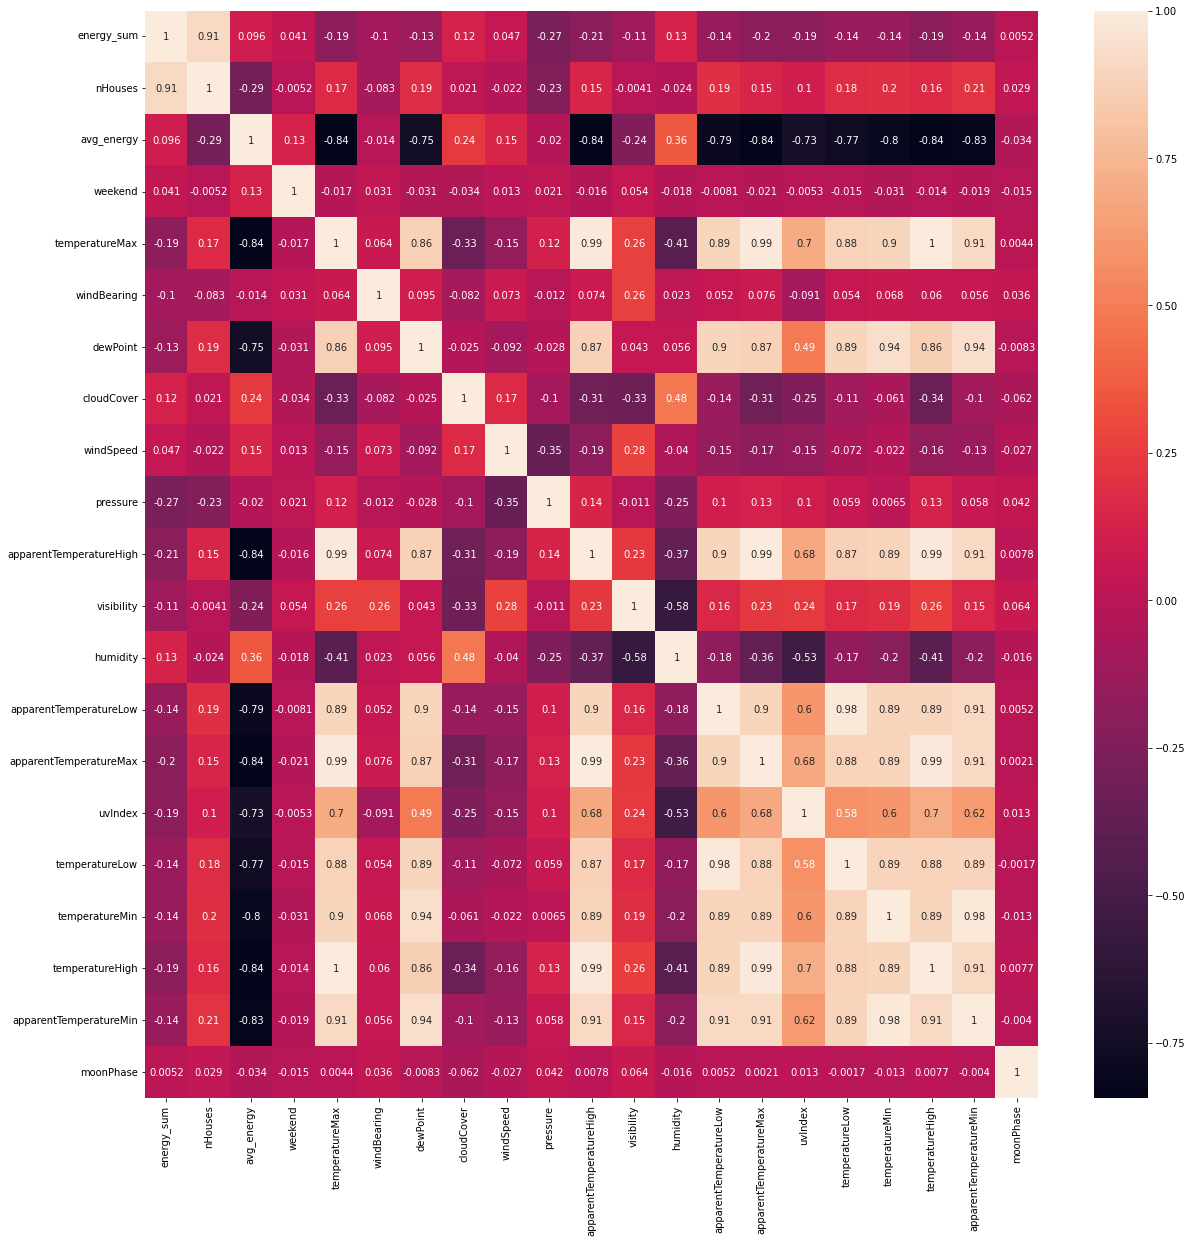

In [ ]:
import seaborn as sns

plt.figure(figsize=(20,20))
sns.heatmap(cor_matrix, annot=True)

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
weather_energy = weather_energy.dropna()
X = weather_energy.drop(columns=["day", 'energy_sum','nHouses','avg_energy','apparentTemperatureHigh','apparentTemperatureLow','apparentTemperatureMax','apparentTemperatureMin']) #'temperatureHigh','pressure','temperatureLow',"visibility"])
y = weather_energy['avg_energy']
estimator = RandomForestRegressor()
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)

In [ ]:
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
weather_energy

,day,energy_sum,nHouses,avg_energy,weekend,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385000,13,6.952692,0,10.36,229,6.29,0.36,2.04,1027.12,10.36,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94
1,2011-11-24,213.412000,25,8.536480,0,12.93,204,8.56,0.41,4.04,1027.22,12.93,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97
2,2011-11-25,303.993000,32,9.499781,0,13.03,243,7.24,0.48,5.02,1024.47,12.27,12.38,0.79,4.69,13.03,1.0,7.01,7.46,12.27,4.84,0.01
3,2011-11-26,420.976000,41,10.267707,1,12.96,237,6.96,0.44,5.75,1025.80,12.96,13.07,0.81,11.59,12.96,1.0,11.59,7.01,12.96,4.69,0.05
4,2011-11-27,444.883001,41,10.850805,1,13.54,256,5.76,0.42,5.48,1021.11,13.54,13.08,0.72,1.31,13.54,1.0,1.31,4.47,13.54,2.94,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,2014-02-24,51994.547004,4994,10.411403,0,14.23,183,6.03,0.50,5.02,1005.19,14.23,13.00,0.74,4.78,14.23,1.0,8.25,7.99,14.23,5.52,0.82
825,2014-02-25,51423.508001,4995,10.294997,0,11.43,202,5.06,0.62,5.69,1000.65,10.31,12.09,0.78,1.67,11.43,1.0,4.17,6.79,10.31,3.89,0.86
826,2014-02-26,50943.305995,4993,10.202945,0,11.29,227,2.74,0.26,3.82,1012.73,11.29,13.00,0.73,3.03,11.29,2.0,6.01,4.17,11.29,1.67,0.90
827,2014-02-27,51678.185998,4990,10.356350,0,10.31,224,3.08,0.32,4.14,1007.02,10.31,12.04,0.74,0.82,10.31,2.0,3.43,3.93,10.31,1.41,0.93


In [ ]:
new_weather_energy = weather_energy.drop(columns=['energy_sum', 'nHouses', 'apparentTemperatureHigh', 'apparentTemperatureLow', 'apparentTemperatureMax', 'apparentTemperatureMin'])
new_weather_energy

,day,avg_energy,weekend,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,temperatureLow,temperatureMin,temperatureHigh,moonPhase
0,2011-11-23,6.952692,0,10.36,229,6.29,0.36,2.04,1027.12,8.06,0.93,1.0,8.24,3.81,10.36,0.94
1,2011-11-24,8.536480,0,12.93,204,8.56,0.41,4.04,1027.22,10.64,0.89,1.0,9.71,8.56,12.93,0.97
2,2011-11-25,9.499781,0,13.03,243,7.24,0.48,5.02,1024.47,12.38,0.79,1.0,7.01,7.46,12.27,0.01
3,2011-11-26,10.267707,1,12.96,237,6.96,0.44,5.75,1025.80,13.07,0.81,1.0,11.59,7.01,12.96,0.05
4,2011-11-27,10.850805,1,13.54,256,5.76,0.42,5.48,1021.11,13.08,0.72,1.0,1.31,4.47,13.54,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,2014-02-24,10.411403,0,14.23,183,6.03,0.50,5.02,1005.19,13.00,0.74,1.0,8.25,7.99,14.23,0.82
825,2014-02-25,10.294997,0,11.43,202,5.06,0.62,5.69,1000.65,12.09,0.78,1.0,4.17,6.79,10.31,0.86
826,2014-02-26,10.202945,0,11.29,227,2.74,0.26,3.82,1012.73,13.00,0.73,2.0,6.01,4.17,11.29,0.90
827,2014-02-27,10.356350,0,10.31,224,3.08,0.32,4.14,1007.02,12.04,0.74,2.0,3.43,3.93,10.31,0.93


### Exercise 8 - Advanced. Training the model 

Use the dataframe your created at exercise 7

A) Study the code below to get insight on how forcasting works.


In [ ]:
new_weather_energy.set_index(['day'],inplace=True)
new_weather_energy

,avg_energy,weekend,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,temperatureLow,temperatureMin,temperatureHigh,moonPhase
day,,,,,,,,,,,,,,,
2011-11-23,6.952692,0,10.36,229,6.29,0.36,2.04,1027.12,8.06,0.93,1.0,8.24,3.81,10.36,0.94
2011-11-24,8.536480,0,12.93,204,8.56,0.41,4.04,1027.22,10.64,0.89,1.0,9.71,8.56,12.93,0.97
2011-11-25,9.499781,0,13.03,243,7.24,0.48,5.02,1024.47,12.38,0.79,1.0,7.01,7.46,12.27,0.01
2011-11-26,10.267707,1,12.96,237,6.96,0.44,5.75,1025.80,13.07,0.81,1.0,11.59,7.01,12.96,0.05
2011-11-27,10.850805,1,13.54,256,5.76,0.42,5.48,1021.11,13.08,0.72,1.0,1.31,4.47,13.54,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-24,10.411403,0,14.23,183,6.03,0.50,5.02,1005.19,13.00,0.74,1.0,8.25,7.99,14.23,0.82
2014-02-25,10.294997,0,11.43,202,5.06,0.62,5.69,1000.65,12.09,0.78,1.0,4.17,6.79,10.31,0.86
2014-02-26,10.202945,0,11.29,227,2.74,0.26,3.82,1012.73,13.00,0.73,2.0,6.01,4.17,11.29,0.90


In [ ]:
model_data = new_weather_energy
# train = model_data.iloc[0:round(len(model_data)*0.90)]
# test = model_data.iloc[len(train)-1:]
train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

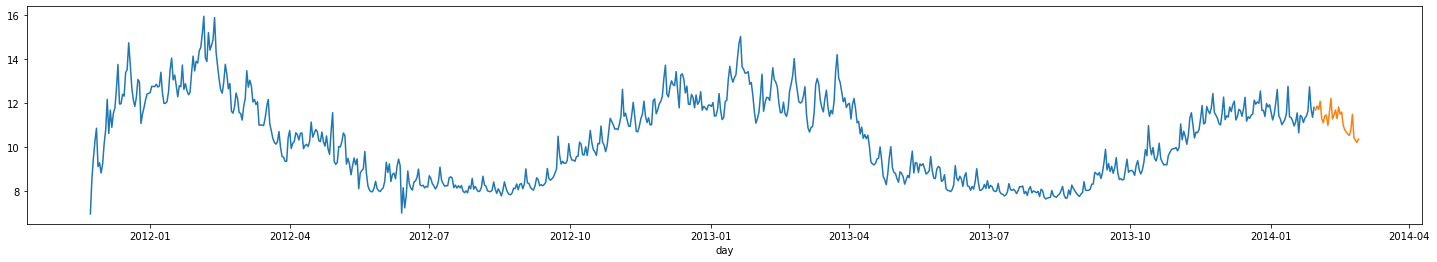

In [ ]:
train['avg_energy'].plot(figsize=(25,4))
test['avg_energy'].plot(figsize=(25,4))


In [ ]:
test.head(1)

,avg_energy,weekend,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,temperatureLow,temperatureMin,temperatureHigh,moonPhase
day,,,,,,,,,,,,,,,
2014-01-30,11.685169,0,5.94,65,3.08,0.81,1.52,1001.76,6.63,0.91,1.0,1.97,3.0,5.94,0.98


In [ ]:
train = train.dropna()
test = test.dropna()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 798 entries, 2011-11-23 to 2014-01-29
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_energy       798 non-null    float64
 1   weekend          798 non-null    int64  
 2   temperatureMax   798 non-null    float64
 3   windBearing      798 non-null    int64  
 4   dewPoint         798 non-null    float64
 5   cloudCover       798 non-null    float64
 6   windSpeed        798 non-null    float64
 7   pressure         798 non-null    float64
 8   visibility       798 non-null    float64
 9   humidity         798 non-null    float64
 10  uvIndex          798 non-null    float64
 11  temperatureLow   798 non-null    float64
 12  temperatureMin   798 non-null    float64
 13  temperatureHigh  798 non-null    float64
 14  moonPhase        798 non-null    float64
dtypes: float64(13), int64(2)
memory usage: 99.8+ KB


In [ ]:
endog = train['avg_energy']
exog = sm.add_constant(train[['temperatureMax','dewPoint','cloudCover','windSpeed','visibility','humidity','uvIndex','temperatureMin','weekend']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7,1,1),seasonal_order=(1,1, 0, 12),trend='c')
model_fit = mod.fit()
model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         avg_energy   No. Observations:                  798
Model:             SARIMAX(7, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -532.518
Date:                            Mon, 18 Oct 2021   AIC                           1107.035
Time:                                    09:33:11   BIC                           1205.015
Sample:                                         0   HQIC                          1144.708
                                            - 798                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0076      0.014     -0.540      0.589      -0.035       0.020
const          -1.323e-08   5.33e-09     -2.481      0.013   -2.37e-08   -2.78e-09
temperatureMax     0.0294      0.015      1.898      0.058      -0.001       0.060
dewPoint          -0.1214      0.030     -4.011      0.000      -0.181      -0.062
cloudCover         0.5375      0.106      5.075      0.000       0.330       0.745
windSpeed          0.0213      0.010      2.084      0.037       0.001       0.041
visibility        -0.0038      0.009     -0.435      0.663      -0.021       0.013
humidity           2.1075      0.668      3.155      0.002       0.798       3.417
uvIndex            0.0649      0.034      1.917      0.055      -0.001       0.131
temperatureMin     0.0035      0.016      0.213      0.831      -0.028       0.035
weekend            0.4691      0.043     10.902      0.000       0.385       0.553
ar.L1             -0.1224      0.199     -0.614      0.539      -0.513       0.268
ar.L2             -0.1422      0.075     -1.906      0.057      -0.289       0.004
ar.L3             -0.1319      0.061     -2.175      0.030      -0.251      -0.013
ar.L4             -0.1458      0.054     -2.708      0.007      -0.251      -0.040
ar.L5             -0.1343      0.053     -2.530      0.011      -0.238      -0.030
ar.L6             -0.0579      0.052     -1.123      0.261      -0.159       0.043
ar.L7              0.1994      0.041      4.857      0.000       0.119       0.280
ma.L1             -0.2228      0.202     -1.104      0.269      -0.618       0.173
ar.S.L12          -0.4723      0.034    -14.095      0.000      -0.538      -0.407
sigma2             0.2259      0.009     24.363      0.000       0.208       0.244
===================================================================================
Ljung-Box (Q):                      194.39   Jarque-Bera (JB):                67.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.81e+16. Standard errors may be unstable.
"""

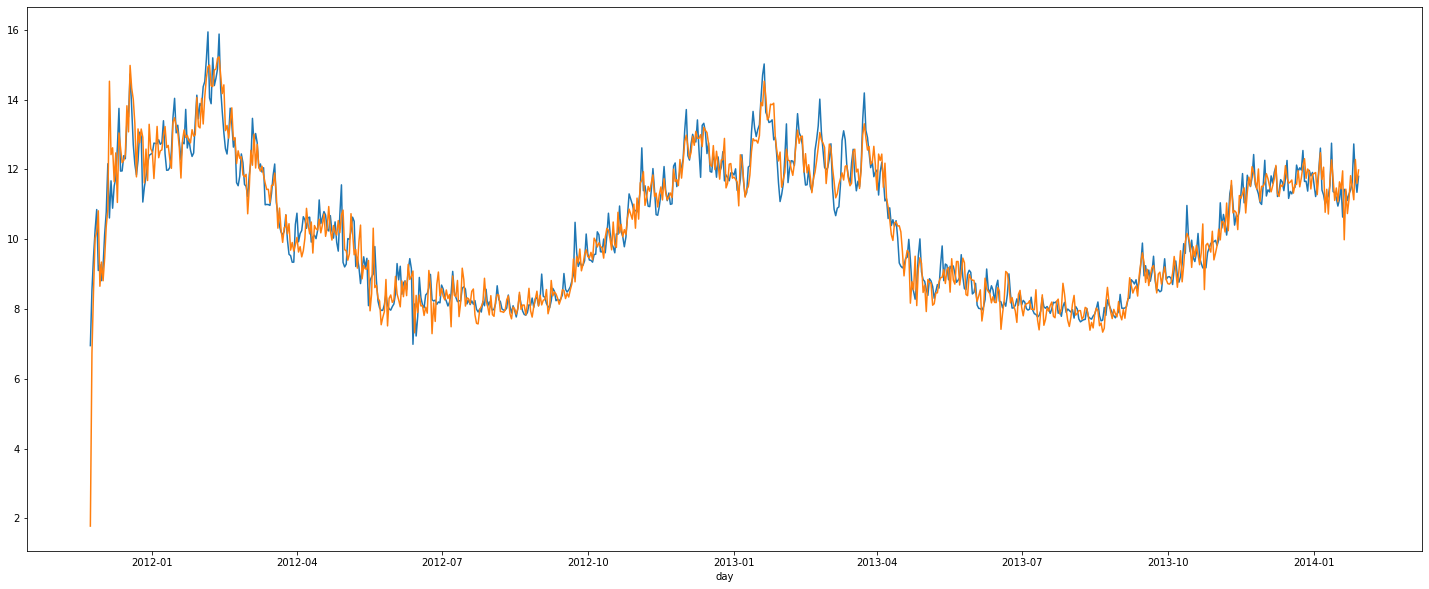

In [ ]:
train['avg_energy'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

In [ ]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['temperatureMax','dewPoint','cloudCover','windSpeed','visibility','humidity','uvIndex','temperatureMin','weekend']]))
test['predicted'] = predict.values
test.tail(5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,avg_energy,weekend,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,temperatureLow,temperatureMin,temperatureHigh,moonPhase,predicted
day,,,,,,,,,,,,,,,,
2014-02-23,11.480411,1,11.94,200,6.17,0.66,7.10,1010.37,12.33,0.76,1.0,7.99,8.67,11.94,0.78,11.270478
2014-02-24,10.411403,0,14.23,183,6.03,0.50,5.02,1005.19,13.00,0.74,1.0,8.25,7.99,14.23,0.82,9.834038
2014-02-25,10.294997,0,11.43,202,5.06,0.62,5.69,1000.65,12.09,0.78,1.0,4.17,6.79,10.31,0.86,10.725601
2014-02-26,10.202945,0,11.29,227,2.74,0.26,3.82,1012.73,13.00,0.73,2.0,6.01,4.17,11.29,0.90,10.858618
2014-02-27,10.356350,0,10.31,224,3.08,0.32,4.14,1007.02,12.04,0.74,2.0,3.43,3.93,10.31,0.93,10.654239


In [ ]:
test['residual'] = abs(test['avg_energy']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['avg_energy']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 0.382337778271807
MAPE: 3.4222918604868666


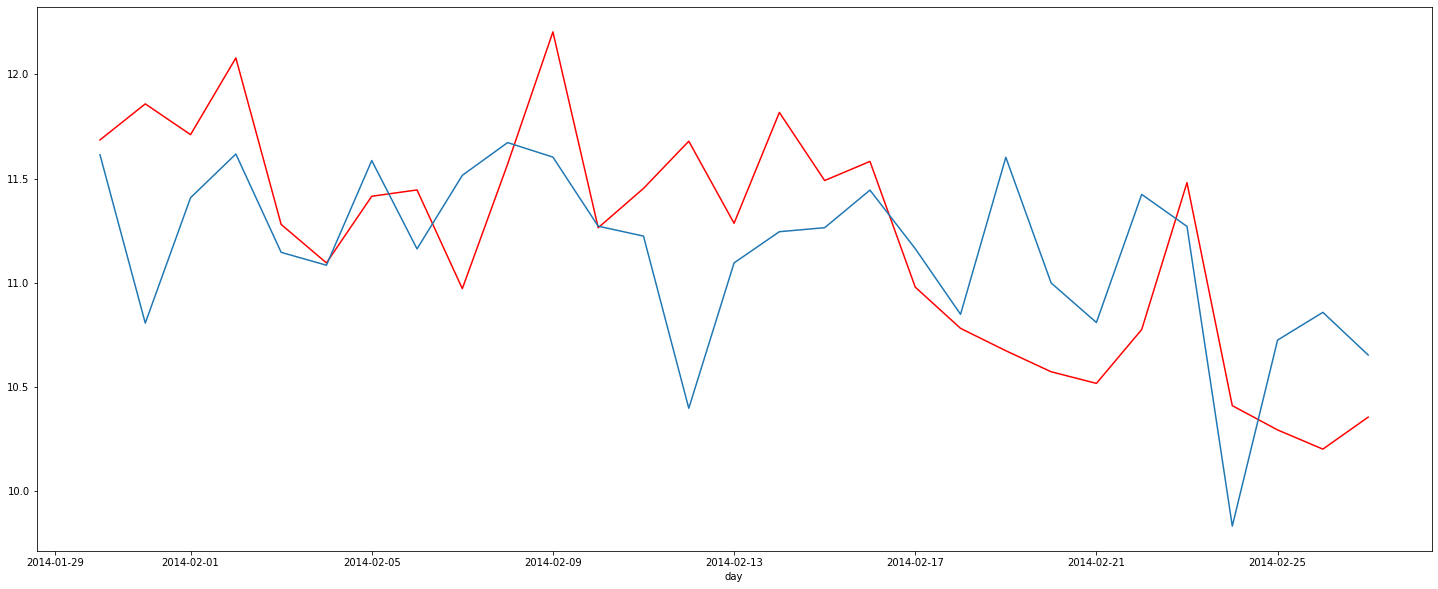

In [ ]:
test['avg_energy'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()